In [1]:
%matplotlib inline

import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

from detrend_func import detrend_func
from window_func import main as window_func

import dask
from distributed import Client, LocalCluster
import dask.array as da

import xarray as xr

In [2]:
# Create a Dask Distributed cluster with one processor and as many
# threads as cores
cluster = LocalCluster(n_workers=1)
client = Client(cluster)

### Define constants to be used

In [3]:
roundnum = 'round3'

dx = 80000. # meters
dy = 80000. # meters
dt = 1 # in days
H = [2000.0, 3000.0, 4000.0]  # meters
Htot = H[0] + H[1] + H[2]
f0 = 9.37456*(10**(-5)) #1/s (Coriolis parameter)
g = [1.2, 0.4]
alpha_bc = 0.2 # nondimensional mixed boundary condition for OCEAN
gamma = 0.5*alpha_bc + 1 # nondimensional number for ease of calculation
mask = 2 # number of cells to mask at boundaries

In [4]:
tile_size = 100

In [5]:
datadir = '/g/data1/v45/pm2987/Spunup_atpa/Test_100yrs_atOnce/'

# METHOD #2: use sorted(glob(os.path.join)) with unix wildcards
# Select the desired files
ncfiles = sorted(glob(os.path.join(datadir, 'output*/atpa.nc'))) # for all files
ncfiles = ncfiles[66:166]
print(ncfiles)

['/g/data1/v45/pm2987/Spunup_atpa/output100/atpa.nc', '/g/data1/v45/pm2987/Spunup_atpa/output101/atpa.nc', '/g/data1/v45/pm2987/Spunup_atpa/output102/atpa.nc', '/g/data1/v45/pm2987/Spunup_atpa/output103/atpa.nc', '/g/data1/v45/pm2987/Spunup_atpa/output104/atpa.nc', '/g/data1/v45/pm2987/Spunup_atpa/output105/atpa.nc', '/g/data1/v45/pm2987/Spunup_atpa/output106/atpa.nc', '/g/data1/v45/pm2987/Spunup_atpa/output107/atpa.nc', '/g/data1/v45/pm2987/Spunup_atpa/output108/atpa.nc', '/g/data1/v45/pm2987/Spunup_atpa/output109/atpa.nc', '/g/data1/v45/pm2987/Spunup_atpa/output110/atpa.nc', '/g/data1/v45/pm2987/Spunup_atpa/output111/atpa.nc', '/g/data1/v45/pm2987/Spunup_atpa/output112/atpa.nc', '/g/data1/v45/pm2987/Spunup_atpa/output113/atpa.nc', '/g/data1/v45/pm2987/Spunup_atpa/output114/atpa.nc', '/g/data1/v45/pm2987/Spunup_atpa/output115/atpa.nc', '/g/data1/v45/pm2987/Spunup_atpa/output116/atpa.nc', '/g/data1/v45/pm2987/Spunup_atpa/output117/atpa.nc', '/g/data1/v45/pm2987/Spunup_atpa/output118/at

Construct a DataArray of all output files (takes a few seconds)

In [6]:
chunks = {'xp': tile_size, 'yp': tile_size, 
          'time':365, 'z':1, 'zi':1}

datasets = [xr.open_dataset(fn, 
                            chunks=chunks)
            for fn in ncfiles]

dsx = xr.concat(datasets, dim='time', coords='all')

### KE

$$
-\frac{H_1}{f_0^3 {H_{tot}}} \mathrm{Re} \left[  \widehat{p_1}^* 
\widehat{J(\nabla_H^2 p_1,p_1)}\right]
- \frac{H_2}{f_0^3 {H_{tot}}} \mathrm{Re} \left[  \widehat{p_2}^* 
\widehat{J(\nabla_H^2 p_2, p_2)}\right]
-\frac{H_3}{f_0^3 {H_{tot}}} \mathrm{Re} \left[  \widehat{p_3}^* 
\widehat{J(\nabla_H^2 p_3, p_3)}\right]
$$

In [7]:
def calc_KE(dsx, tile_index, z=0):
    
    # Select variable
    p = dsx.p.isel(z=z)

    # Select specified tile, with 2-cell padding for taking of derivatives
    ix, iy = tile_index
    p_start = p.isel(yp=slice(max(iy*tile_size-2,0), (iy+1)*tile_size+2), 
                       xp=slice(0,1))
    p_start2 = p.isel(yp=slice(max(iy*tile_size-2,0), (iy+1)*tile_size+2), 
                       xp=slice(1,2))
    p_end = p.isel(yp=slice(max(iy*tile_size-2,0), (iy+1)*tile_size+2), 
                       xp=slice(-1,None))
    p_end2 = p.isel(yp=slice(max(iy*tile_size-2,0), (iy+1)*tile_size+2), 
                       xp=slice(-2,-1))
    p = p.isel(yp=slice(max(iy*tile_size-2,0), (iy+1)*tile_size+2),
               xp=slice(max(ix*tile_size-2,0), (ix+1)*tile_size+2))
    xp = p.xp.values # grab values of dask arrays
    yp = p.yp.values
    time = p.time.values
    
    p = p.data
    p_start = p_start.data
    p_start2 = p_start2.data
    p_end = p_end.data
    p_end2 = p_end2.data
    print('p_start.shape = ',p_start.shape,'p_end.shape = ',p_end.shape)
    print('p shape with buffer of 2 on either side = ',p.shape)
    
    
    # Concatenate two columns/rows on ends for correct handling of boundaries in derivatives
    if ix==0:
        p = da.concatenate([p_end, p], axis=1)
        p = da.concatenate([p_end2, p], axis=1)
        print('in ix=0',p.shape)
    if ix==3:
        p = da.concatenate([p, p_start], axis=1)
        p = da.concatenate([p, p_start2], axis=1)
    if iy==0:
        p = da.concatenate([(2./gamma)*p[slice(0,1),:,:] + ((gamma-2)/gamma)*p[slice(1,2),:,:], p], axis=0)
        print('in iy=0',p.shape)
        p = da.concatenate([(2. + 4./gamma)*p[slice(1,2),:,:] - (6. + 4./gamma)*p[slice(2,3),:,:] + 7.*p[slice(3,4),:,:] - 2.*p[slice(4,5),:,:], p], axis=0)
        print('in iy=0',p.shape)
        #p = da.concatenate([((4+alpha_bc+0.5*alpha_bc**2)/(gamma**2))*p[slice(1,2),:,:] - (4/(gamma**2))*p[slice(2,3),:,:] + ((gamma-alpha_bc)/gamma)*p[slice(3,4),:,:], p], axis=0)
    if iy==0:
        p = da.concatenate([(2./gamma)*p[slice(-1,None),:,:] + ((gamma-2)/gamma)*p[slice(-2,-1),:,:], p], axis=0)
        p = da.concatenate([(2. + 4./gamma)*p[slice(-2,-1),:,:] - (6. + 4./gamma)*p[slice(-3,-2),:,:] + 7.*p[slice(-4,-3),:,:] - 2.*p[slice(-5,-4),:,:], p], axis=0)
        #p = da.concatenate([((4+alpha_bc+0.5*alpha_bc**2)/(gamma**2))*p[slice(-2,-1),:,:] - (4/(gamma**2))*p[slice(-3,-2),:,:] + ((gamma-alpha_bc)/gamma)*p[slice(-4,-3),:,:], p], axis=0)
    
    # Update size variables
    ny, nx, nt = p.shape
    print('after adding two cells for boundaries ',p.shape)
    p = p.rechunk(chunks={0: ny, 1: nx})
        
    def Jacobian(p):
        # Jacobian stencil
        p_cc = p
        p_ac = np.roll(p_cc,  2, axis=0)
        p_bc = np.roll(p_cc,  1, axis=0)
        p_dc = np.roll(p_cc, -1, axis=0)
        p_ec = np.roll(p_cc, -2, axis=0)
    
        p_ca = np.roll(p_cc, -2, axis=1)
        p_cb = np.roll(p_cc, -1, axis=1)
        p_cd = np.roll(p_cc,  1, axis=1)
        p_ce = np.roll(p_cc,  2, axis=1)
    
        p_bb = np.roll(p_bc, -1, axis=1)
        p_bd = np.roll(p_bc,  1, axis=1)
        p_db = np.roll(p_dc, -1, axis=1)
        p_dd = np.roll(p_dc,  1, axis=1) 
        
        p_y = - p_cd + p_cb
        p_x = - p_bc + p_dc
        delp_y = - (p_ce + p_bd + p_dd - 4*p_cd) + (p_ca + p_bb + p_db - 4*p_cb)
        delp_x = - (p_bb + p_ac + p_bd - 4*p_bc) + (p_db + p_ec + p_dd - 4*p_dc)
    
        J = delp_x*p_y - delp_y*p_x
        
        return J

    # Evaluate the Jacobian function
    J = p.map_blocks(Jacobian)
    
    # Trim off added cells
    J = J[2:ny-2, 2:nx-2, :]
    p = p[2:ny-2, 2:nx-2, :]
    #J = J[:, 2:nx-2, :]
    #p = p[:, 2:nx-2, :]
    
    # Mask boundaries, if desired (mask = number of cells to mask on each boundary)
    #if ix == 0 and mask:
    #    J = J[:,slice(mask,None),:]
    #    p = p[:,slice(mask,None),:]
    if iy == 0 and mask:
        J = J[slice(mask,None),:,:]
        p = p[slice(mask,None),:,:]
    #if ix == 3 and mask:
    #    J = J[:,slice(0,-mask),:]
    #    p = p[:,slice(0,-mask),:]
    if iy == 0 and mask:
        J = J[slice(0,-mask),:,:]
        p = p[slice(0,-mask),:,:]
        
    print('after masking 2 cells at boundary ',J.shape)

    # Multiplicative factor due to derivative
    J = (1./(4*(dx**4)))*J
    
    # Use smaller spatial chunks for fft
    J = J.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})
    p = p.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})
    
    print('p shape after chunking/10 = ',p.shape)
        
    # Function that detrends, windows, and takes fft
    def fft_block(var):
        var = detrend_func(var,'time')
        var = window_func(var,'time')
        varhat = (1./var.shape[2])*np.fft.rfft(var, axis=2)
        return varhat
    
    # Execute fft function above
    Jhat = J.map_blocks(fft_block)
    phat = p.map_blocks(fft_block)
    
    Jhat = Jhat.rechunk(chunks={0: tile_size, 1:tile_size, 2: 365})
    phat = phat.rechunk(chunks={0: tile_size, 1:tile_size, 2: 365})

    # Multiply by constants
    KE = -(H[z] / (f0**3 * Htot)) * ((phat.conj()*Jhat).real)
    
    print('final shape = ',KE.shape)

    # Sum over x- and y-axes
    KE = da.sum(KE, axis=(0,1))
    
    KE = KE.compute()
    
    # Wrap as DataArray
    n = len(time)
    d = time[1] - time[0]
    freq = np.fft.rfftfreq(n, d)
    
    KE = xr.DataArray(KE, 
                      dims=['freq'], 
                      coords={'freq': freq,
                              'xp': xp.mean(),
                              'yp': yp.mean()})
    
    return KE

In [8]:
%%time
result = calc_KE(dsx,(0,0),z=1)

p_start.shape =  (97, 1, 36500) p_end.shape =  (97, 1, 36500)
p shape with buffer of 2 on either side =  (97, 102, 36500)
in ix=0 (97, 104, 36500)
in iy=0 (98, 104, 36500)
in iy=0 (99, 104, 36500)
after adding two cells for boundaries  (101, 104, 36500)
after masking 2 cells at boundary  (93, 100, 36500)
p shape after chunking/10 =  (93, 100, 36500)
final shape =  (93, 100, 36500)
CPU times: user 29 s, sys: 3.34 s, total: 32.3 s
Wall time: 1min 41s


(18251,)


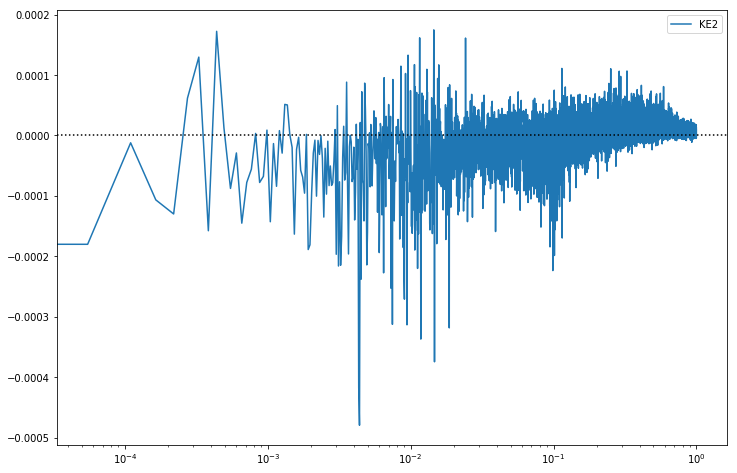

In [9]:
print(result.shape)
ktiso = (2./(100*365))*np.arange(0,np.floor(100*365.0/2)+1)

plt.figure(figsize=(12,8))
plt.semilogx(ktiso,result,label='KE2')
plt.axhline(0,color='k',linestyle='dotted')
plt.legend()

np.save('KE2_dsx00_CODE1_'+roundnum,result)